In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.optim import Adam
from tqdm import tqdm

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 100

In [5]:
# batch size x channels x time x bands
valid_part = torch.rand((32, 1, 128, 64))

In [6]:
def print_model_details(model):
    print("Model Parameter Details:")
    total_params = 0
    for name, parameter in model.named_parameters():
        param_count = parameter.numel()
        total_params += param_count
        print(f"{name}: {param_count:,} parameters")
    print(f"\nTotal Model Parameters: {total_params:,}")

In [7]:
class HeadBlock(nn.Module):
    def __init__(self, input_features: int, output_classes: int):
        super().__init__()

        self.layers = nn.ModuleList(
            [
                nn.Flatten(),
                nn.Linear(input_features, 128),
                nn.Dropout2d(p=0.5),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.Dropout2d(p=0.5),
                nn.ReLU(),
                nn.Linear(64, output_classes),
            ]
        )

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

In [8]:
block_test = HeadBlock(8192, 5)
block_test(valid_part).shape

/opt/anaconda3/envs/ml/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


torch.Size([32, 5])

In [9]:
print_model_details(block_test)

Model Parameter Details:
layers.1.weight: 1,048,576 parameters
layers.1.bias: 128 parameters
layers.4.weight: 8,192 parameters
layers.4.bias: 64 parameters
layers.7.weight: 320 parameters
layers.7.bias: 5 parameters

Total Model Parameters: 1,057,285


In [10]:
import torch
import torch.nn as nn


class LSTMAttentionFeatureBlock(nn.Module):
    def __init__(
        self,
        input_channels: int,
        output_channels: int,
        hidden_size: int = 32,
        num_heads: int = 1,
        lstm_layers: int = 1,
        dropout_rate: float = 0.2,
    ):
        super().__init__()

        self.input_projection = nn.Conv2d(input_channels, hidden_size, kernel_size=1)

        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout_rate if lstm_layers > 1 else 0,
        )

        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            dropout=dropout_rate,
            batch_first=True,
        )

        self.output_projection = nn.Sequential(
            nn.Conv2d(hidden_size, output_channels, kernel_size=1),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout2d(p=dropout_rate),
        )

    def forward(self, x):
        projected = self.input_projection(x)

        batch_size, channels, height, width = projected.shape
        lstm_input = projected.permute(0, 2, 3, 1).reshape(
            batch_size, height * width, channels
        )

        lstm_out, _ = self.lstm(lstm_input)

        attn_out, _ = self.multihead_attn(lstm_out, lstm_out, lstm_out)

        attn_reshaped = attn_out.reshape(batch_size, height, width, channels).permute(
            0, 3, 1, 2
        )

        out = self.output_projection(attn_reshaped)
        return out

In [11]:
class FeatureExtractionBlock(nn.Module):
    def __init__(
        self,
        input_channels: int,
        output_channels: int,
        conv_kernel_size: int = 3,
        conv_stride: int = 2,
        conv_padding: int = 1,
        pooling_kernel_size: int = 2,
    ):
        super().__init__()

        self.layers = nn.ModuleList(
            [
                nn.Conv2d(
                    input_channels,
                    output_channels,
                    kernel_size=conv_kernel_size,
                    stride=conv_stride,
                    padding=conv_padding,
                ),
                nn.LeakyReLU(negative_slope=0.01),
                nn.MaxPool2d(kernel_size=pooling_kernel_size),
                nn.BatchNorm2d(output_channels),
                nn.Dropout2d(p=0.2),
            ]
        )

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

In [12]:
class FeatureExtractor(nn.Module):
    def __init__(
        self, input_channels: int, base_channels: int = 32, num_blocks: int = 3
    ):
        super().__init__()

        self.blocks = nn.ModuleList()

        for i in range(num_blocks):
            in_channels = input_channels if i == 0 else base_channels * (2 ** (i - 1))
            out_channels = base_channels * (2**i)

            # if i % 2 == 0:
            #     block = FeatureExtractionBlock(
            #         input_channels=in_channels, output_channels=out_channels
            #     )
            # else:
            block = LSTMAttentionFeatureBlock(
                input_channels=in_channels, output_channels=out_channels
            )

            self.blocks.append(block)

        self.global_pool = nn.AdaptiveAvgPool2d(1)

        self.output_projection = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                base_channels * (2 ** (num_blocks - 1)), base_channels * (2**num_blocks)
            ),
        )

    def forward(self, x):
        for block in self.blocks:
            x = block(x)

        x = self.global_pool(x)
        x = self.output_projection(x)

        return x

In [13]:
extraction_test = FeatureExtractor(1, 32, 5)
print_model_details(extraction_test)

Model Parameter Details:
blocks.0.input_projection.weight: 32 parameters
blocks.0.input_projection.bias: 32 parameters
blocks.0.lstm.weight_ih_l0: 4,096 parameters
blocks.0.lstm.weight_hh_l0: 4,096 parameters
blocks.0.lstm.bias_ih_l0: 128 parameters
blocks.0.lstm.bias_hh_l0: 128 parameters
blocks.0.multihead_attn.in_proj_weight: 3,072 parameters
blocks.0.multihead_attn.in_proj_bias: 96 parameters
blocks.0.multihead_attn.out_proj.weight: 1,024 parameters
blocks.0.multihead_attn.out_proj.bias: 32 parameters
blocks.0.output_projection.0.weight: 1,024 parameters
blocks.0.output_projection.0.bias: 32 parameters
blocks.0.output_projection.1.weight: 32 parameters
blocks.0.output_projection.1.bias: 32 parameters
blocks.1.input_projection.weight: 1,024 parameters
blocks.1.input_projection.bias: 32 parameters
blocks.1.lstm.weight_ih_l0: 4,096 parameters
blocks.1.lstm.weight_hh_l0: 4,096 parameters
blocks.1.lstm.bias_ih_l0: 128 parameters
blocks.1.lstm.bias_hh_l0: 128 parameters
blocks.1.multihea

In [ ]:
extraction_test(valid_part).shape

In [ ]:
class BirdClassifier(nn.Module):
    def __init__(
        self,
        input_channels: int,
        output_classes: int,
        validation_tensor: torch.Tensor,
        base_channels: int = 32,
        num_blocks: int = 3,
    ):
        super().__init__()

        self.extractor = FeatureExtractor(
            input_channels, base_channels, num_blocks=num_blocks
        )
        output = self.extractor(validation_tensor)
        head_input_features = output.shape[1]
        self.head = HeadBlock(head_input_features, output_classes)

    def forward(self, x):
        x = self.extractor(x)
        return self.head(x)

In [ ]:
class BirdClassifierManager:
    def __init__(
        self,
        output_classes: int,
        input_channels: int,
        validation_tensor: torch.Tensor,
        load_model: bool = False,
        model_path="./bird_classifier.pth",
        device: str = DEVICE,
        base_channels: int = 32,
        num_blocks: int = 3,
    ):
        self.model_path = model_path
        self.device = device
        if load_model:
            self.load_model()
        else:
            self.model = BirdClassifier(
                input_channels,
                output_classes,
                validation_tensor,
                base_channels=base_channels,
                num_blocks=num_blocks,
            ).to(self.device)

        self.validation_tensor = validation_tensor

    def validate(self):
        try:
            self.model(self.validation_tensor)
            print("OK!")
        except Exception as e:
            print(f"Validation failed: {e}")

    def predict(self, sample: torch.Tensor):
        sample = sample.to(self.device)
        with torch.no_grad():
            return self.model(sample)

    def save_model(self):
        torch.save(self.model, self.model_path)

    def load_model(self):
        self.model.load_state_dict(torch.load(self.model_path))
        self.model.to(self.device)

    def train(
        self, train: Dataset, valid: Dataset, epochs: int = EPOCHS, lr: float = 0.0001
    ):
        criterion = nn.CrossEntropyLoss()
        optimizer = Adam(self.model.parameters(), lr=lr)

        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in tqdm(train):
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct_train += predicted.eq(labels).sum().item()
                total_train += labels.size(0)

            train_loss /= len(train)
            train_accuracy = 100 * correct_train / total_train

            if epoch % 5 == 0:
                self.save_model()

            self.model.eval()
            valid_loss = 0.0
            correct_valid = 0
            total_valid = 0

            with torch.no_grad():
                for inputs, labels in valid:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    loss = criterion(outputs, labels)

                    valid_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    correct_valid += predicted.eq(labels).sum().item()
                    total_valid += labels.size(0)

            valid_loss /= len(valid)
            valid_accuracy = 100 * correct_valid / total_valid

            print(
                f"Epoch [{epoch+1}/{epochs}] "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% "
                f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%"
            )

    def test(self, test: Dataset):
        self.model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = outputs.max(1)
                correct_test += predicted.eq(labels).sum().item()
                total_test += labels.size(0)

        test_accuracy = 100 * correct_test / total_test
        print(f"Test Accuracy: {test_accuracy:.2f}%")

In [ ]:
import os
import torchaudio
import numpy as np
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
class BirdSongDataset(Dataset):
    def __init__(
        self,
        x: pd.DataFrame,
        y: pd.DataFrame,
        sample_rate: int,
        num_samples: int,
        as_mel_spectogram: bool = True,
    ):
        super().__init__()
        self.x = x
        self.y = y
        self.target_sample_rate = sample_rate
        self.target_number_of_samples = num_samples
        self.as_mel_spectogram = as_mel_spectogram
        self.mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.target_sample_rate, n_fft=1024, hop_length=512, n_mels=96
        )

    def _resample_if_necessary(self, waveform: torch.Tensor, sample_rate: int):
        if sample_rate != self.target_sample_rate:
            resample_transform = torchaudio.transforms.Resample(
                orig_freq=sample_rate, new_freq=self.target_sample_rate
            )
            waveform = resample_transform(waveform)
        return waveform

    def _pad_or_trim(self, waveform: torch.Tensor):
        if waveform.shape[1] > self.target_number_of_samples:
            waveform = waveform[:, : self.target_number_of_samples]
        elif waveform.shape[1] < self.target_number_of_samples:
            padding = self.target_number_of_samples - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        return waveform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        path, class_ = self.x[index], self.y[index]

        waveform, sample_rate = torchaudio.load(str(path))
        waveform = self._resample_if_necessary(waveform, sample_rate)
        waveform = self._pad_or_trim(waveform)

        if self.as_mel_spectogram:
            waveform = self.mel_spectrogram_transform(waveform)

        return waveform, class_

In [ ]:
import torchaudio
import os
import pandas as pd
from torch.utils.data import DataLoader
from pathlib import Path


class BirdSongDatasetManager:
    def __init__(
        self,
        csv_file_path: Path,
        audio_files_main_folder: Path,
        train: float = 0.9,
        valid: float = 0.05,
        test: float = 0.05,
        batch_size: int = 32,
        shuffle: bool = True,
        csv_file_name: str = "train_mod.csv",
        minimum_files_num=100,
        min_duration_seconds=40,
        sample_rate: int = 32000,
        num_samples: int = 960_000,
    ):
        if not np.isclose((train + valid + test), 1):
            raise Exception("Sum of dataset partitions must be equal to 1")

        self.csv_file_path = csv_file_path
        self.audio_files_main_folder = audio_files_main_folder
        self.train = train
        self.valid = valid
        self.test = test
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.csv_file_name = csv_file_name
        self.number_of_classes = 0
        self.minimum_files_num = minimum_files_num
        self.min_duration_seconds = min_duration_seconds

        self.index_to_class, self.class_to_index = dict(), dict()

        self.dataframe, self.species_to_name = self._filter_data(
            self.csv_file_path, self.audio_files_main_folder
        )
        self.species_in_dataset = self.dataframe["ebird_code"].unique()

        self.mapped_dataframe = self._map_bird_to_path()

        self.dataset_loaders_args = dict(
            sample_rate=sample_rate, num_samples=num_samples
        )

    def _filter_data(
        self, csv_file_path: Path, audio_files_main_folder: Path
    ) -> pd.DataFrame:
        dataframe = pd.read_csv(csv_file_path)

        current_dataset_species = os.listdir(audio_files_main_folder)
        current_dataset_species.remove(self.csv_file_name)

        ebird_code_to_name = dict()
        class_ = 0
        for species in current_dataset_species:
            species_path = audio_files_main_folder / species
            if len(os.listdir(species_path)) >= self.minimum_files_num:
                name = dataframe[dataframe["ebird_code"] == species].iloc[0]["species"]

                self.class_to_index[name] = class_
                self.index_to_class[class_] = name
                ebird_code_to_name[species] = name

                class_ += 1

        self.number_of_classes = class_

        # Filter dataframe by valid species only
        valid_species = dataframe[
            dataframe["ebird_code"].isin(ebird_code_to_name.keys())
        ]

        return valid_species, ebird_code_to_name

    def _map_bird_to_path(self) -> pd.DataFrame:
        data = []
        for species in self.species_in_dataset:
            prefix = self.audio_files_main_folder / species
            audio_files = os.listdir(prefix)
            for file in audio_files:
                file_path = prefix / file

                class_code = self.species_to_name[species]
                data.append(
                    {
                        "class": self.class_to_index[class_code],
                        "file_path": file_path,
                        "class_name": class_code,
                        "ebird_code": species,
                    }
                )

                # Only include files that are at least the minimum duration
                # if duration_seconds >= self.min_duration_seconds:

        return pd.DataFrame(data)

    def get_datasets(self, with_valid: bool = True):
        train_data = []
        valid_data = []
        test_data = []

        # Filter only species with valid files based on the duration
        valid_species = self.mapped_dataframe.groupby("ebird_code").filter(
            lambda group: len(group) >= self.minimum_files_num
        )
        print(
            f"Number of species with at least {self.minimum_files_num} files: {len(valid_species['ebird_code'].unique())}"
        )

        min_group_size = min(valid_species.groupby("ebird_code").size())
        print(
            f"Minimum group size (after filtering species with fewer than {self.minimum_files_num} files): {min_group_size}"
        )

        for _, group in valid_species.groupby("ebird_code"):
            # Sample to ensure equal group size across all species
            group = group.sample(n=min_group_size, random_state=42).reset_index(
                drop=True
            )
            n = len(group)
            train_end = int(self.train * n)
            valid_end = train_end + int(self.valid * n) if with_valid else train_end

            train_data.append(group.iloc[:train_end])
            if with_valid:
                valid_data.append(group.iloc[train_end:valid_end])
                test_data.append(group.iloc[valid_end:])
            else:
                test_data.append(group.iloc[train_end:])

        # Concatenate the data into DataFrames
        train_df = pd.concat(train_data).reset_index(drop=True)
        valid_df = pd.concat(valid_data).reset_index(drop=True) if with_valid else None
        test_df = pd.concat(test_data).reset_index(drop=True)

        # Create DataLoaders
        train = DataLoader(
            BirdSongDataset(
                train_df["file_path"], train_df["class"], **self.dataset_loaders_args
            ),
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )

        valid = (
            DataLoader(
                BirdSongDataset(
                    valid_df["file_path"],
                    valid_df["class"],
                    **self.dataset_loaders_args,
                )
            )
            if with_valid
            else None
        )

        test = DataLoader(
            BirdSongDataset(
                test_df["file_path"], test_df["class"], **self.dataset_loaders_args
            )
        )

        return train, valid, test

In [ ]:
dataset_manager = BirdSongDatasetManager(Path("data/train_mod.csv"), Path("data"))

In [ ]:
dataset_manager.class_to_index

{'Evening Grosbeak': 0,
 'Canyon Wren': 1,
 'Northern Raven': 2,
 'Carolina Wren': 3,
 'Dark-eyed Junco': 4,
 'Caspian Tern': 5,
 'Common Grackle': 6,
 'Chipping Sparrow': 7,
 'Canada Warbler': 8,
 'Common Tern': 9,
 'Field Sparrow': 10,
 'Red Fox Sparrow': 11,
 'Common Redpoll': 12,
 'Eastern Towhee': 13,
 'Eastern Wood Pewee': 14,
 'Downy Woodpecker': 15,
 'Canada Goose': 16,
 'Common Yellowthroat': 17,
 'Eurasian Collared Dove': 18,
 'Cactus Wren': 19,
 'Chestnut-sided Warbler': 20,
 'Eastern Meadowlark': 21}

In [ ]:
train_part, valid_part, test_part = dataset_manager.get_datasets()

Number of species with at least 100 files: 22
Minimum group size (after filtering species with fewer than 100 files): 100


In [ ]:
x = next(iter(train_part))
x[0].shape, x[1]

(torch.Size([32, 1, 96, 1876]),
 tensor([13,  0,  4, 10, 14, 15,  6,  8,  5, 21, 16, 18,  9, 14, 11,  6, 13,  7,
         15,  9, 16, 21,  0, 15,  9, 11, 15,  9, 19, 18,  3,  2]))

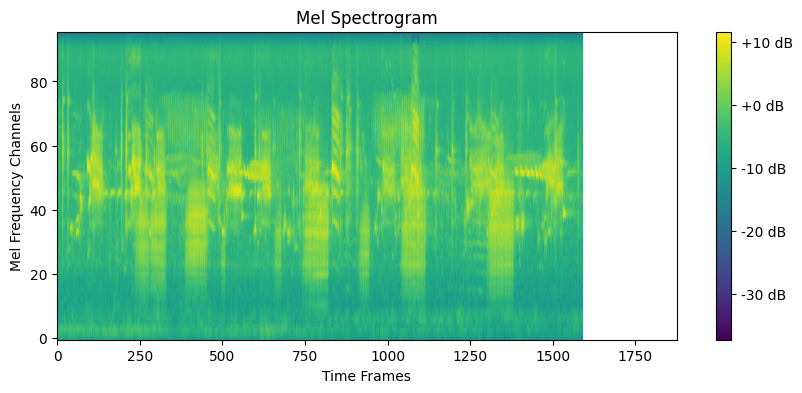

In [ ]:
plt.figure(figsize=(10, 4))
plt.imshow(
    x[0][5].log2()[0, :, :].numpy(), aspect="auto", origin="lower", cmap="viridis"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Channels")
plt.show()

In [ ]:
valid = x[0]
model_manager = BirdClassifierManager(
    dataset_manager.number_of_classes, 1, valid, base_channels=16, num_blocks=1
)
print_model_details(model_manager.model)

NameError: name 'x' is not defined

In [ ]:
model_manager.validate()
model_manager.predict(valid).shape

In [ ]:
model_manager.train(train_part, valid_part)

NameError: name 'model_manager' is not defined